<a href="https://colab.research.google.com/github/Amelrich/Capstone-Fall-2020/blob/master/romane_fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tslearn

     |████████████████████████████████| 778kB 2.8MB/s 


In [2]:
!pip install -U yellowbrick

     |████████████████████████████████| 276kB 2.8MB/s 
  Found existing installation: yellowbrick 0.9.1
    Uninstalling yellowbrick-0.9.1:
      Successfully uninstalled yellowbrick-0.9.1


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tslearn.clustering import TimeSeriesKMeans
from scipy.fftpack import fft,ifft


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [16]:
#max
from time_series_utils import TS_generator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [4]:
class TS_generator:
  def __init__(self, nb_timeseries=2000, chunk_size=100):
    
    self.chunk_size = chunk_size
    self.nb_timeseries = nb_timeseries

    #Retrieve the stocks names
    self.symbols = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/sp500.csv', index_col=False)
    self.symbols = list(self.symbols['Symbol'].values)
    self.symbols = ['BF-B' if x=='BF.B' else x for x in self.symbols]
    self.symbols = ['BRK-B' if x=='BRK.B' else x for x in self.symbols]

    self.list_df = []

    #Build the random time series
    self.build_()

  def build_(self):    
    for _ in range(self.nb_timeseries):

      #Pick a random stock
      stock = self.symbols[np.random.randint(len(self.symbols))]
      TS = pd.read_csv('https://raw.githubusercontent.com/Amelrich/Capstone-Fall-2020/master/data/'+stock+'.csv')
      
      #Pick a random starting point
      timemax = len(TS) - self.chunk_size
      start = np.random.randint(timemax)
      stock_df = TS[start : start+self.chunk_size]

      self.list_df.append( stock_df )

  def get_list_of_df(self):
    #
    return self.list_df

  def get_array(self):
    #Return adjusted close array
    close_array = np.zeros((self.nb_timeseries, self.chunk_size))

    for i in range(self.nb_timeseries):
      close_array[i,:] = self.list_df[i]['Adj Close'].to_numpy()

    return close_array

In [25]:
nb_timeseries = 2000

gen = TS_generator(nb_timeseries=nb_timeseries, chunk_size=100) #default values but just for the syntax
X = gen.get_array()

In [26]:
#Apply MinMax Scaling
X_scaled = MinMaxScaler().fit_transform(X.T).T

#Apply Fourier Transform for test
X_ft = fft(X_scaled)
print(X_ft[0][:10]) #first 10 coefficients

[50.32950747-0.j         10.88032908+8.49073372j  2.85520988+7.69869936j
 -3.66063496-3.52670073j -0.62033419+0.46611671j  0.06647847-0.32680407j
 -1.11687328-1.68341538j -1.48895412+3.37672577j  0.84069473+0.97854907j
 -0.10046599+0.29766173j]


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
C:\Users\Max Tchibozo\AppData\Roaming\Python\Python36\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


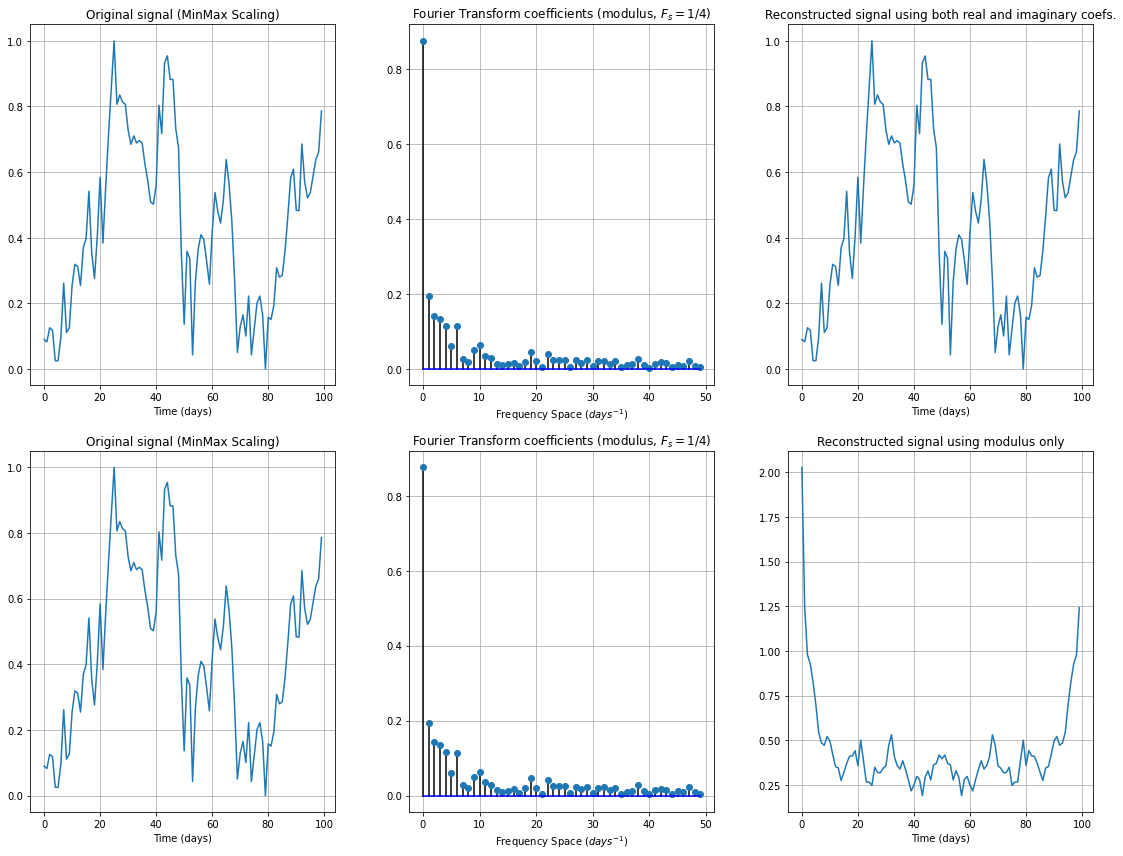

In [6]:
#First approach: Use modulus only
i=0
j=2

# sampling rate: f_max /2 - let's say the smallest pattern is 2 days
Fs = 1/4 
n = X_scaled.shape[1]
fr = Fs/2 * np.linspace(0,1,n//2)
X_ft_mod = 2/n * abs(X_ft)[:,0:np.size(fr)]

X_ft_reconstructed = ifft(abs(X_ft)).real
X_ft_complex_reconstructured = ifft(X_ft)

fig, axes = plt.subplots(2,3,figsize=(16,12))

axes[0,0].plot(X_scaled[i])
axes[0,0].set_xlabel('Time (days)')
axes[0,0].set_title('Original signal (MinMax Scaling)')
axes[0,0].grid()

axes[0,1].set_title('Fourier Transform coefficients (modulus, $F_s = 1/4 $)')
axes[0,1].stem(X_ft_mod[i],linefmt='k',basefmt='b')
axes[0,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[0,1].grid()

axes[0,2].plot(X_ft_complex_reconstructured[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[0,2].set_title('Reconstructed signal using both real and imaginary coefs.')
axes[0,2].set_xlabel('Time (days)')
axes[0,2].grid()

axes[1,0].plot(X_scaled[i])
axes[1,0].set_xlabel('Time (days)')
axes[1,0].set_title('Original signal (MinMax Scaling)')
axes[1,0].grid()

axes[1,1].set_title('Fourier Transform coefficients (modulus, $F_s = 1/4 $)')
axes[1,1].stem(X_ft_mod[i],linefmt='k',basefmt='b')
axes[1,1].set_xlabel('Frequency Space ($days^{-1}$)')
axes[1,1].grid()

axes[1,2].plot(X_ft_reconstructed[i])
#axes[0,2].plot(ifft(X_ft_mod[i]))
axes[1,2].set_title('Reconstructed signal using modulus only')
axes[1,2].set_xlabel('Time (days)')
axes[1,2].grid()

plt.tight_layout()
plt.show()

## 1. Concatenate Imaginary and Real Parts

In [11]:
#real/imaginary concat
X_ft_subs_ri = []

for i in X_ft:
    X_ft_subs_ri.append(i[1:12])

X_ft_subs_ri = np.array(X_ft_subs_ri)
X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)

X_ft_subs_ri[:5]

array([[-5.20420251e+00, -2.43666159e-01,  2.26179977e+00,
        -1.51595928e+00, -2.15455261e-01, -1.96645430e+00,
         1.36190852e+00,  3.73474610e-01,  2.41878854e+00,
        -3.00090708e+00,  1.08400397e+00, -8.18388389e+00,
         7.10959620e+00,  6.30042826e+00,  5.58250216e+00,
        -3.04536018e+00,  5.40211329e+00,  5.90247920e-02,
         9.10961837e-01,  7.53726393e-01,  1.05053463e+00,
         1.37897123e+00],
       [ 2.63949361e+00, -1.32535900e+00,  2.52963604e+00,
        -2.01807342e+00, -1.14057646e+00, -7.66045282e-02,
        -3.91691169e-02, -6.32295794e-01, -1.70448003e-02,
        -9.87118872e-02, -5.88918331e-01,  1.80656950e+01,
         8.91836055e+00,  3.88762253e+00,  2.01348205e+00,
         2.84069244e+00,  2.10769417e+00,  1.71078814e+00,
         1.51516561e+00,  2.35456255e+00,  1.34277966e+00,
         1.76618390e+00],
       [-9.06050053e-01, -2.89812982e+00, -1.54220938e+00,
         2.66941200e-01, -4.21364925e-01,  6.37667921e-01,
    

In [15]:
X_ft_subs_ri.shape

(1989, 22)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


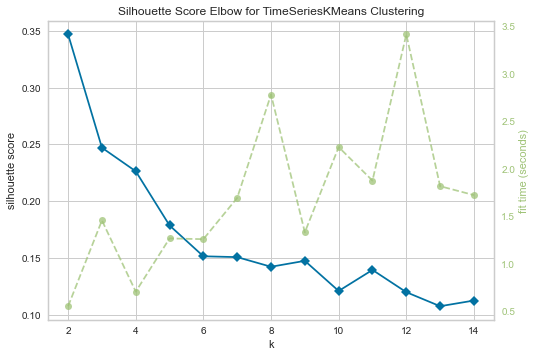

In [12]:
#Find best k
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

model1 = TimeSeriesKMeans()
visualizer = KElbowVisualizer(model1, k=(2,15), metric='silhouette')

visualizer.fit(X_ft_subs_ri)        # Fit the data to the visualizer
visualizer.show();

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 1989 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


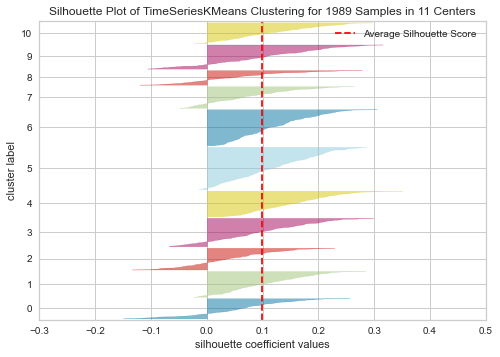

In [13]:
#silhouette scores for each cluster for best k
model1 = TimeSeriesKMeans(n_clusters=11)
visualizer = SilhouetteVisualizer(model1, colors='yellowbrick')
visualizer.fit(X_ft_subs_ri) 
visualizer.show()

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 1989 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


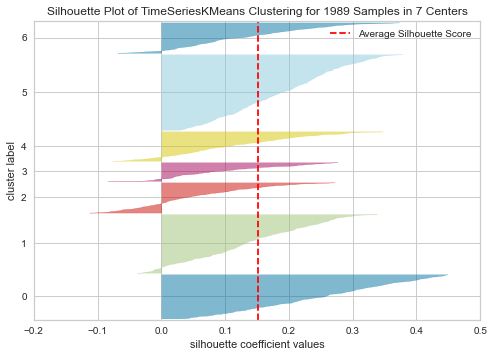

In [14]:
model_ri = TimeSeriesKMeans(n_clusters=7)
visualizer_ri = SilhouetteVisualizer(model_ri, colors='yellowbrick')
visualizer_ri.fit(X_ft_subs_ri) 
visualizer_ri.show()

## 2. Module

In [12]:
#taking only the modulus
X_ft_subs = []

for i in X_ft:
  X_ft_subs.append(i[1:13])

X_ft_subs = np.array(X_ft_subs)
X_ft_subs = X_ft_subs.real
X_ft_subs[:10]

array([[-1.30060361e+00,  1.22279218e+00,  4.47438430e+00,
        -3.40083037e+00, -6.70846266e-01, -1.04452028e+00,
         8.96924425e-01, -1.75396160e-01, -8.20376456e-01,
        -3.87415040e-02,  5.26915929e-01, -4.96350374e-01],
       [-4.30960937e+00, -3.88554328e-01,  1.10921044e+00,
        -6.64159696e-01,  1.79199586e+00, -8.73641305e-01,
         1.44075088e-01, -2.41562194e-02, -4.42603711e-01,
        -7.20709892e-02, -8.83461313e-01,  5.76497696e-02],
       [-9.15059834e+00,  9.40098504e-01, -3.03653887e+00,
         5.49106856e-01, -1.17437693e+00, -1.76194682e-01,
         2.59727353e-01, -1.59213046e+00, -1.21640993e+00,
        -1.39175647e+00,  7.43724359e-01, -5.43518098e-01],
       [-2.34099184e+00,  8.73376017e+00, -2.35453538e+00,
         3.56327097e+00,  4.29834152e+00, -1.30019486e+00,
        -2.22416194e+00,  2.56535196e-01, -4.55265507e-01,
         8.05767913e-01, -5.33400229e-01, -3.31397192e-01],
       [ 5.10507482e+00, -4.68314140e+00, -2.1925665

/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/utils/kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
/usr/local/lib/python3.6/dist-packages/yellowbrick/cluster/elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


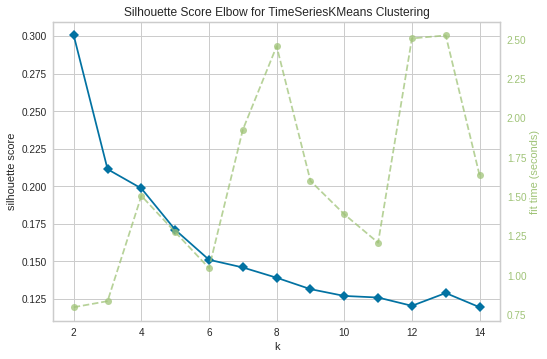

In [13]:
#Find best k
model2 = TimeSeriesKMeans()
visualizer2 = KElbowVisualizer(model2, k=(2,15), metric = 'silhouette')

visualizer2.fit(X_ft_subs)       # Fit the data to the visualizer
visualizer2.show();

/usr/local/lib/python3.6/dist-packages/tslearn/utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 2000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


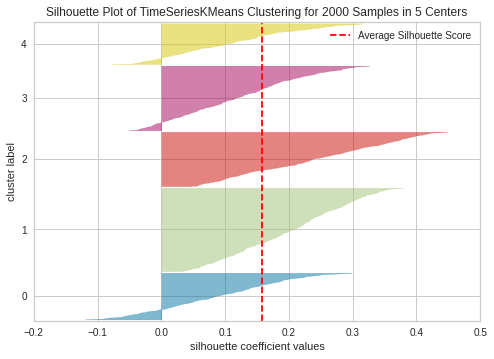

In [14]:
model2 = TimeSeriesKMeans(n_clusters=5)
visualizer2 = SilhouetteVisualizer(model2, colors='yellowbrick')
visualizer2.fit(X_ft_subs_ri) 
visualizer2.show()   

## 3. Optimization of the number of coefficient

### 3.1 Imaginary + real

2 to 3 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


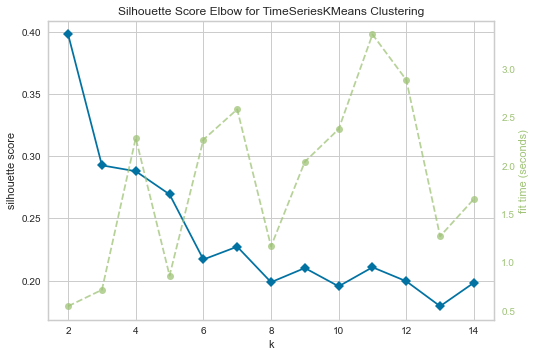

2 to 4 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


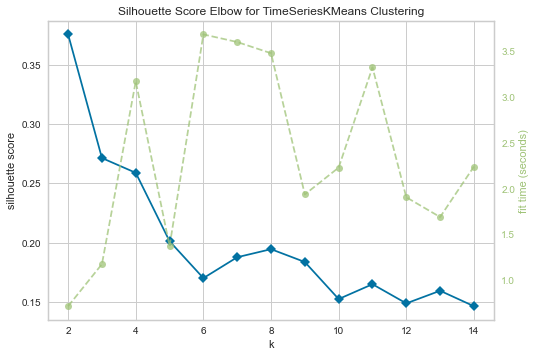

2 to 5 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


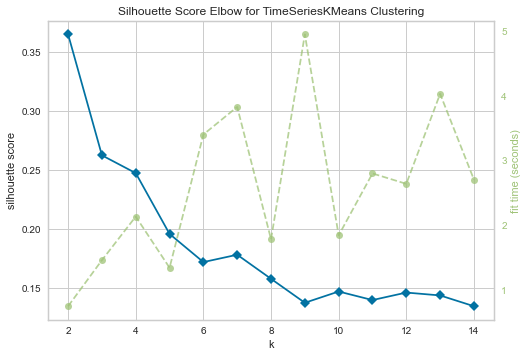

2 to 6 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


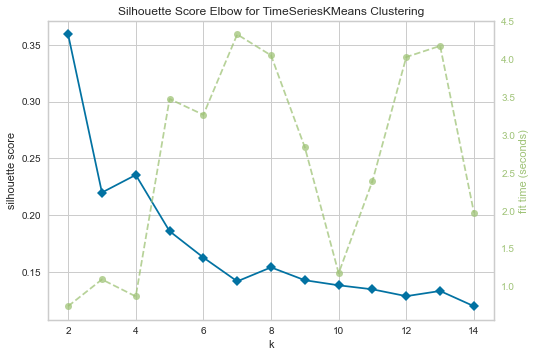

2 to 7 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


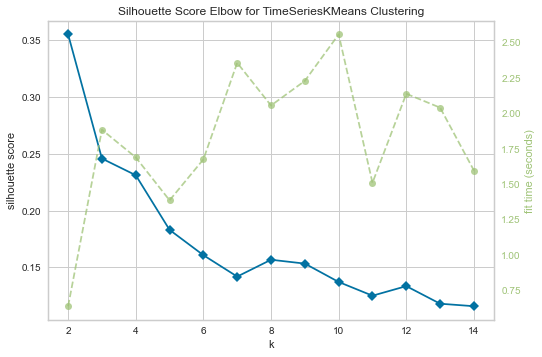

2 to 8 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


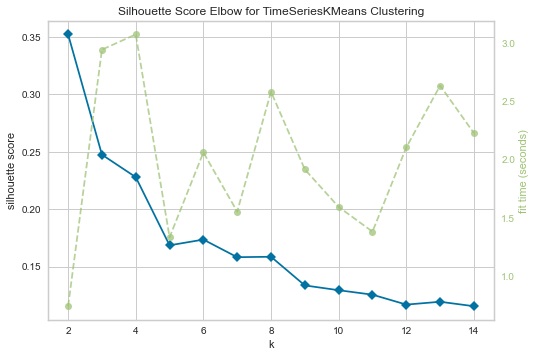

2 to 9 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


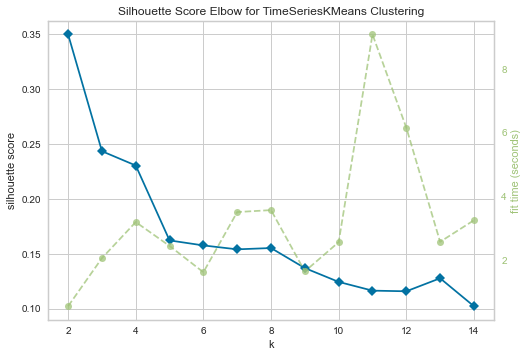

2 to 10 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


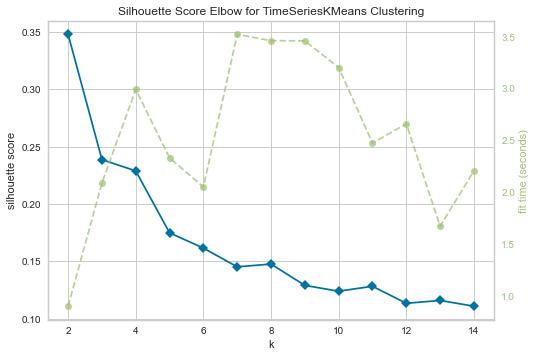

2 to 11 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


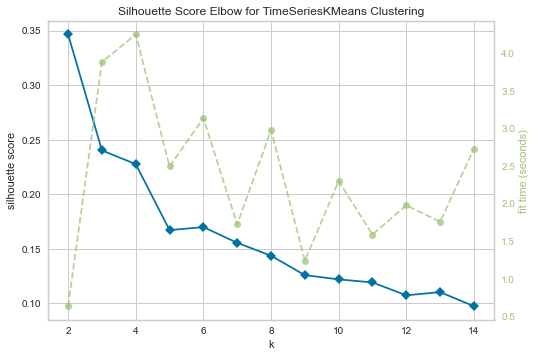

2 to 12 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


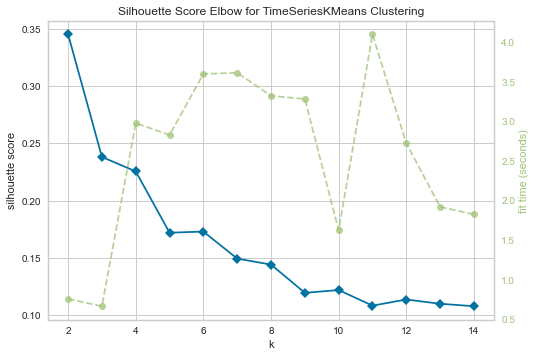

2 to 13 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


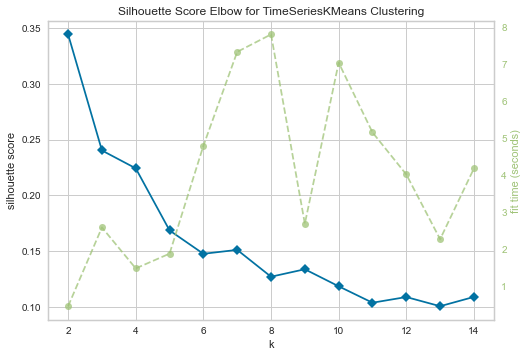

In [27]:
for j in range(3,14):

  X_ft_subs_ri = []

  for i in X_ft:
    X_ft_subs_ri.append(i[1:j])

  X_ft_subs_ri = np.array(X_ft_subs_ri)
  X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)

  model_ri_best = TimeSeriesKMeans()
  visualizer_ri_best = KElbowVisualizer(model_ri_best, k=(2,15), metric = 'silhouette')

  print('2 to', j, 'coefficients')
  visualizer_ri_best.fit(X_ft_subs_ri)       # Fit the data to the visualizer
  visualizer_ri_best.show();



###  3.1 (cont.) Amaury's method for optimal number of coefficients (imaginary+real)

2 to 3 coefficients
6


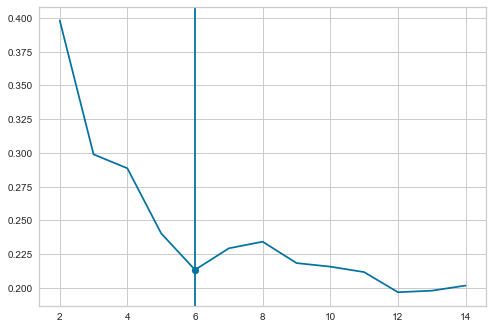

2 to 4 coefficients
6


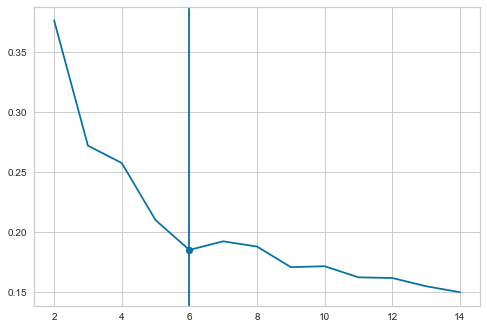

2 to 5 coefficients
6


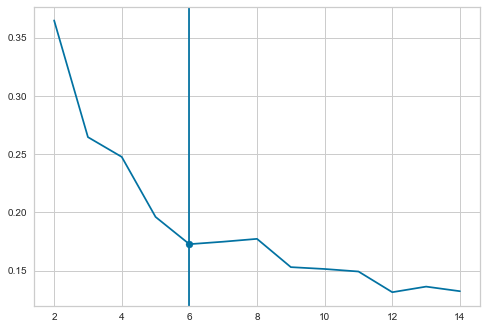

2 to 6 coefficients
6


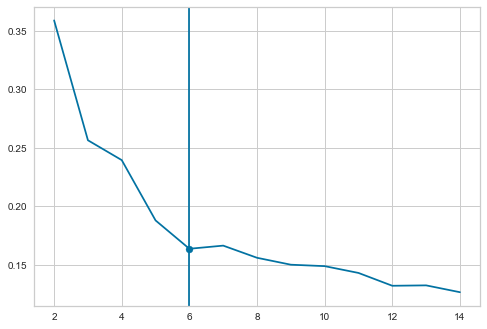

2 to 7 coefficients
6


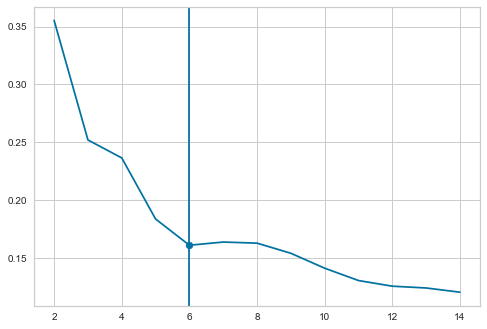

2 to 8 coefficients
6


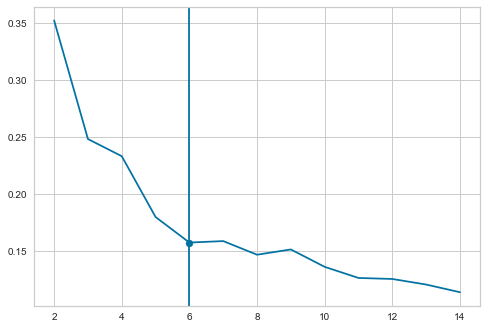

2 to 9 coefficients
6


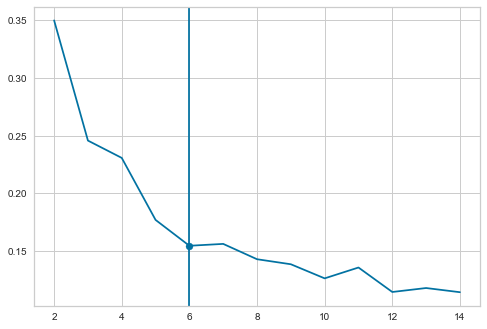

2 to 10 coefficients
6


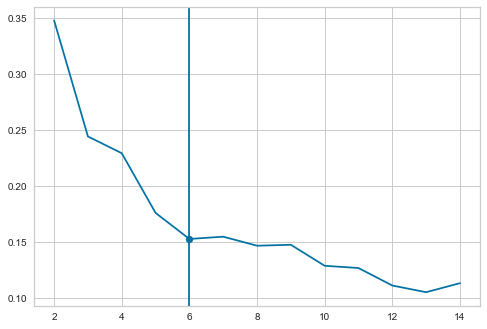

2 to 11 coefficients
6


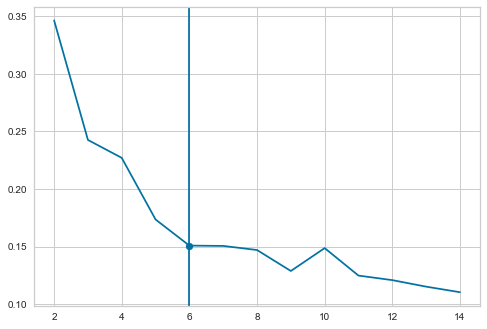

2 to 12 coefficients
6


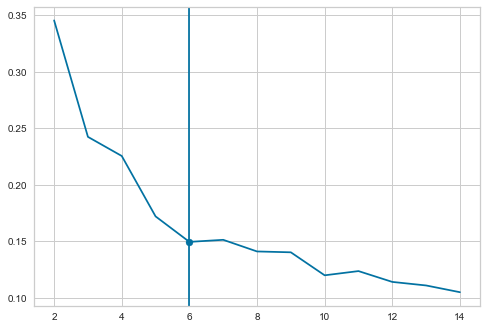

2 to 13 coefficients
6


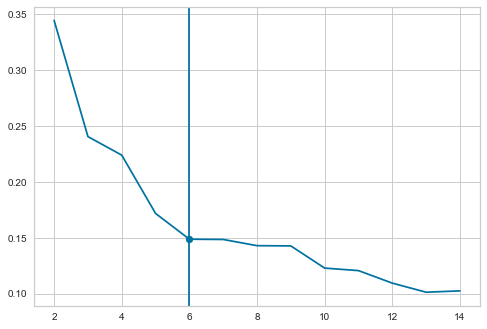

In [28]:
#Max & Romane
def elbow(score_tab):
    a = (score_tab[-1] - score_tab[0]) / len(score_tab)
    b = score_tab[0]
    elb_tab = [ np.abs(score_tab[i] - a*i - b) / np.sqrt(a*a + 1) for i in range(len(score_tab)) ]
    return elb_tab.index(max(elb_tab))  


for j in range(3,14):
    #using fewer coefficients != setting coefficients to zero
    X_ft_subs_ri = X_ft[:,1:j].copy()
    print('2 to', j, 'coefficients')
    X_ft_subs_ri = np.concatenate((X_ft_subs_ri.real,X_ft_subs_ri.imag),axis=1)
    silhouette_scores = []
    for k in range(2,15):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_ft_subs_ri)
        X_ft_subs_ri_assignments = kmeans.predict(X_ft_subs_ri)
        silhouette_scores.append(silhouette_score(X_ft_subs_ri,X_ft_subs_ri_assignments))
    opt_k = elbow(silhouette_scores) + 2 #k starts at 2 (whereas the first index from Amaury's method is 0)
    print(opt_k)
    plt.figure()
    plt.plot(range(2,15),silhouette_scores)
    plt.axvline(x=opt_k)
    plt.scatter([opt_k],[silhouette_scores[opt_k-2]]) #the first value in silhouette_scores corresponds to k=2
    plt.show()


### 3.2 Using only real coefficients

2 to 3 coefficients


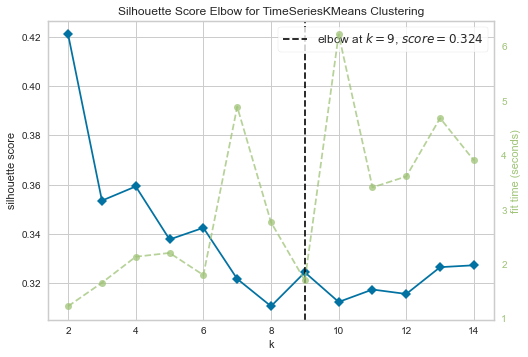

2 to 4 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


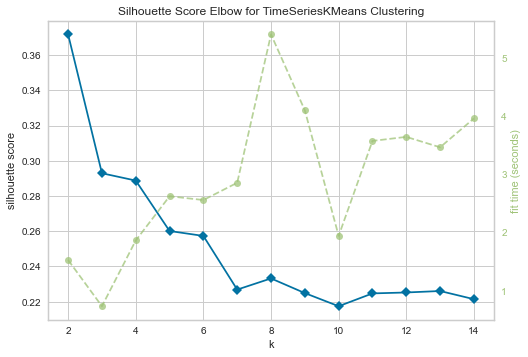

2 to 5 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


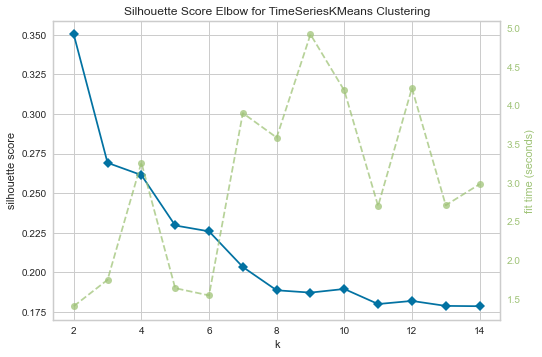

2 to 6 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


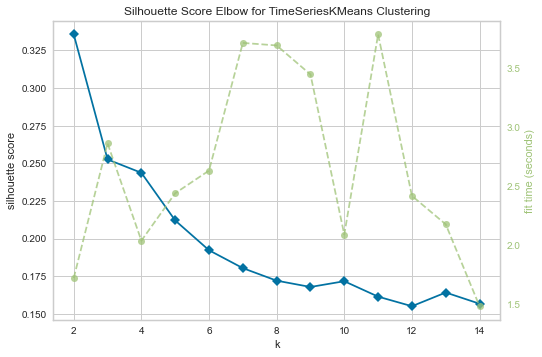

2 to 7 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


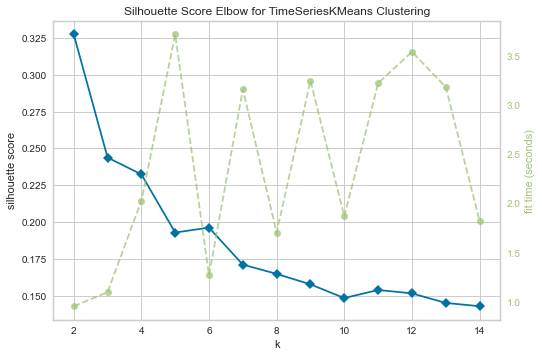

2 to 8 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


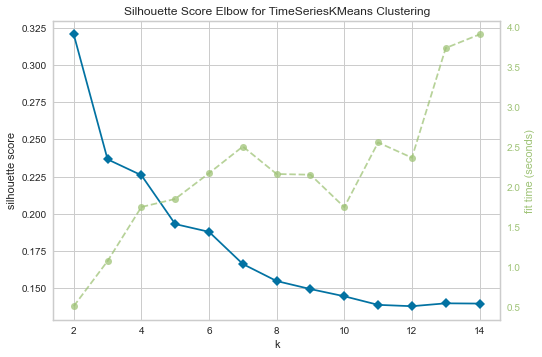

2 to 9 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


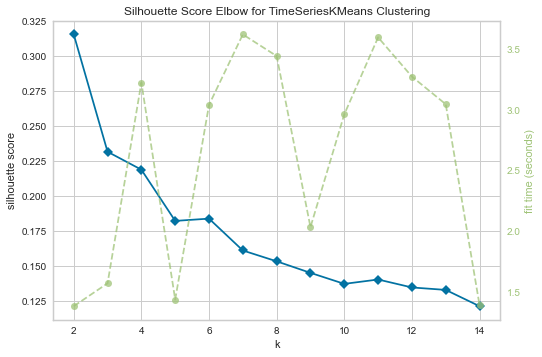

2 to 10 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


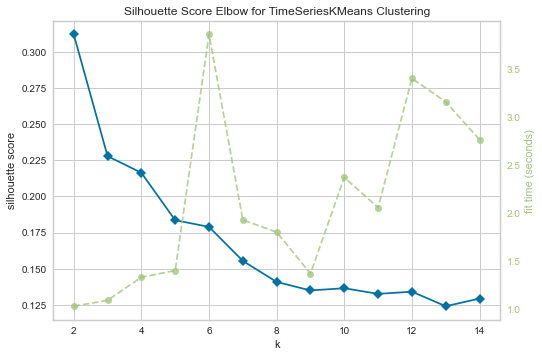

2 to 11 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


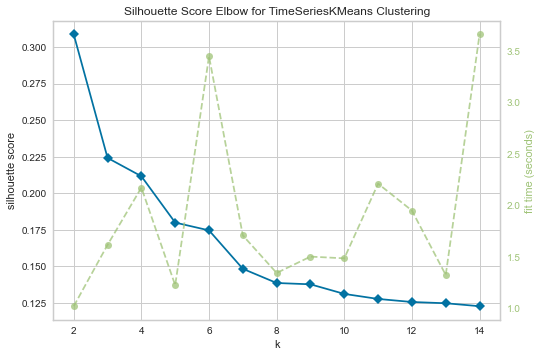

2 to 12 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


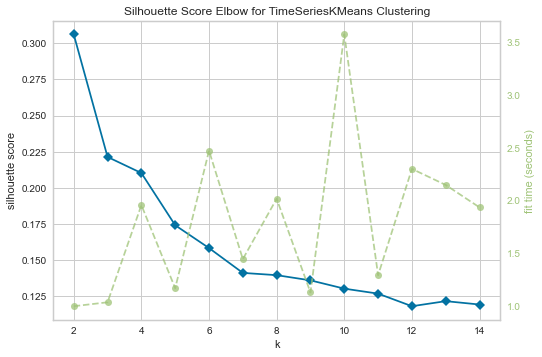

2 to 13 coefficients


C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:182: YellowbrickWarning: No "knee" or "elbow point" detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


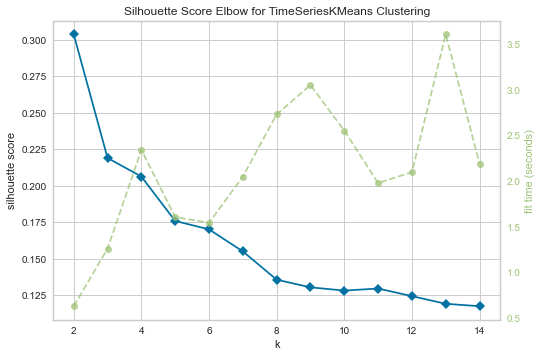

In [29]:
for j in range(3,14):

    X_ft_subs = []

    for i in X_ft:
        X_ft_subs.append(i[1:j])

    X_ft_subs = np.array(X_ft_subs)
    X_ft_subs = X_ft_subs.real
    X_ft_subs[:10]

    model_subs_best = TimeSeriesKMeans()
    visualizer_subs_best = KElbowVisualizer(model_subs_best, k=(2,15), metric = 'silhouette')

    print('2 to', j, 'coefficients')
    visualizer_subs_best.fit(X_ft_subs)       # Fit the data to the visualizer
    visualizer_subs_best.show();



### 3.2 Amaury's method (using only real coefficients)

2 to 3 coefficients
5


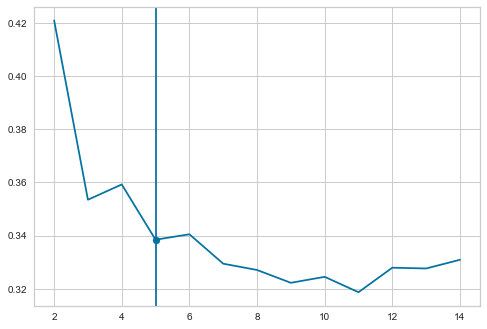

2 to 4 coefficients
7


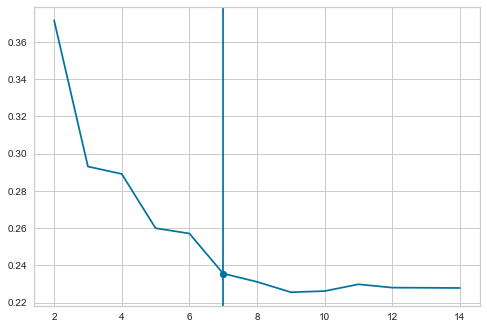

2 to 5 coefficients
5


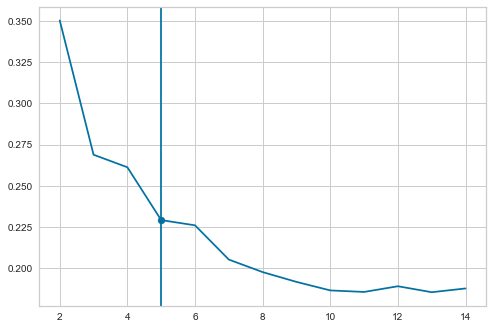

2 to 6 coefficients
5


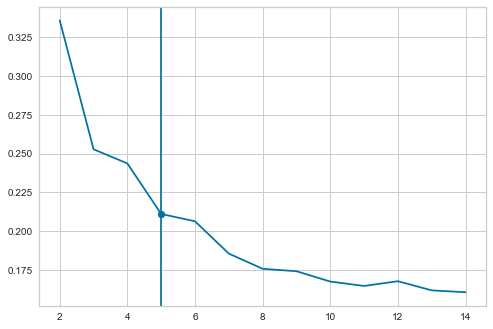

2 to 7 coefficients
7


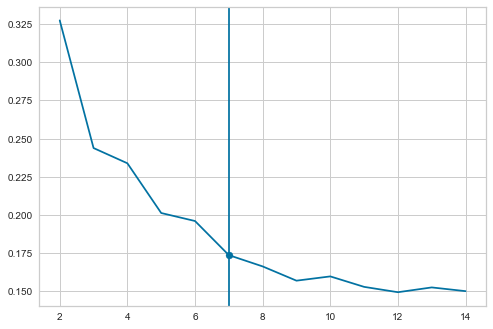

2 to 8 coefficients
5


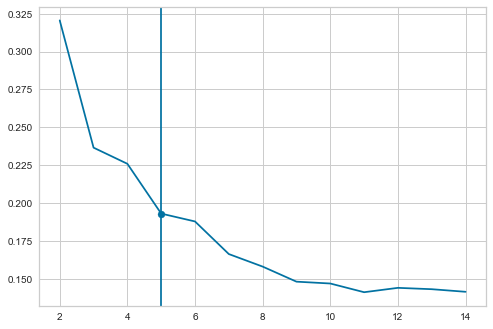

2 to 9 coefficients
5


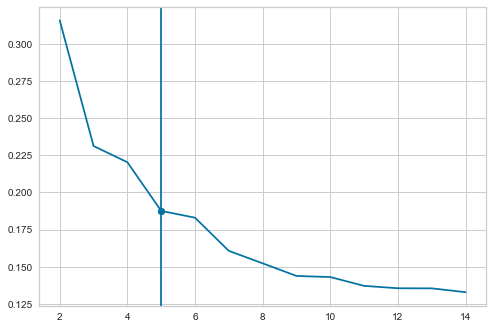

2 to 10 coefficients
7


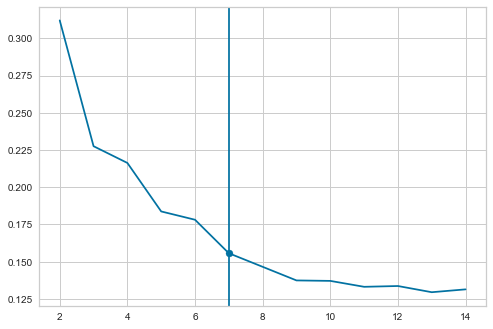

2 to 11 coefficients
5


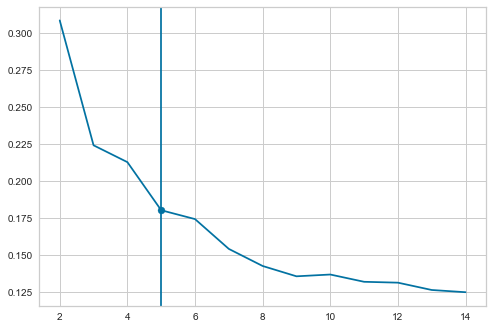

2 to 12 coefficients
5


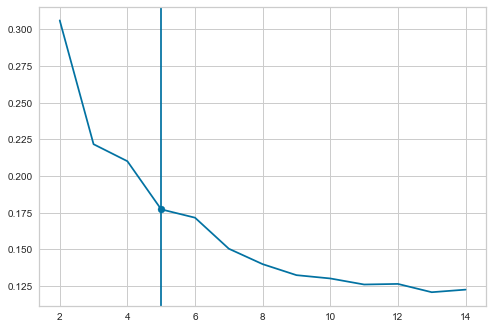

2 to 13 coefficients
5


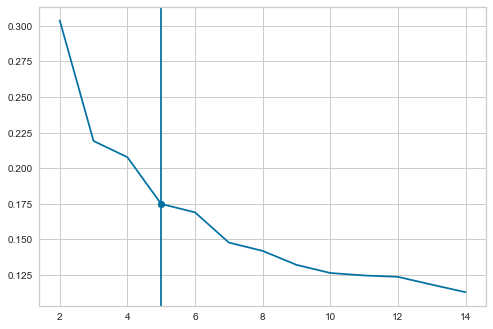

In [30]:
#Max & Romane
for j in range(3,14):
    #using fewer coefficients != setting coefficients to zero
    X_ft_subs_ri = X_ft[:,1:j].copy()
    X_ft_subs_ri = X_ft_subs_ri.real
    print('2 to', j, 'coefficients')
    silhouette_scores = []
    for k in range(2,15):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X_ft_subs_ri)
        X_ft_subs_ri_assignments = kmeans.predict(X_ft_subs_ri)
        silhouette_scores.append(silhouette_score(X_ft_subs_ri,X_ft_subs_ri_assignments))
    opt_k = elbow(silhouette_scores) + 2 #k starts at 2 (whereas the first index from Amaury's method is 0)
    print(opt_k)
    plt.figure()
    plt.plot(range(2,15),silhouette_scores)
    plt.axvline(x=opt_k)
    plt.scatter([opt_k],[silhouette_scores[opt_k-2]]) #the first value in silhouette_scores corresponds to k=2
    plt.show()